# Evaluation Code

In [1]:
import pandas as pd
from visibility import Visibility
from glob import glob
import trimesh as tm
import pickle
import os
import numpy as np
from scipy.sparse import lil_matrix
from tqdm import tqdm

mesh_base_dir = '/data/scannet_subset_all_gt'
code_base_dir = os.getcwd()

def get_irradiance_matrix(vis_tester,sampling_places):
    total_faces = vis_tester.mesh.mesh.faces.shape[0]
    irradiance_matrix = lil_matrix((sampling_places.shape[0],total_faces))
    for i in range(sampling_places.shape[0]):
        _,irradiance = vis_tester.render(id0 =None,id1 = None,pos = sampling_places[i,:].tolist())
        irradiance = irradiance
        irradiance_matrix[i,np.where(irradiance > 0)] = irradiance[irradiance > 0]

    return irradiance_matrix.tocsr()

def evaluate_semantic_disinfection_performance(roadmap):
    mesh_name = roadmap.split('/')[-4]
    # we then load the mesh original mesh and its ground truth:
    mesh_gt_file = os.path.join(mesh_base_dir, 'gt_{}.ply'.format(mesh_name))
    ground_truth_visibility = Visibility(mesh_gt_file,res = 512, useShader = True,createWnd = True)
    main_dir = os.path.dirname(roadmap)
    reachable_file = os.path.join(main_dir,'armbot_reachable_330_divs.p')
    solutions_file = os.path.join(main_dir,'armbot_solutions_330_divs.p')
    sampling_places_file = os.path.join(main_dir,'armbot_sampling_places_330_divs.p')

    reachable = pickle.load(open(reachable_file,'rb'))
    solutions = np.array(pickle.load(open(solutions_file,'rb'))[0])
    sampling_places = pickle.load(open(sampling_places_file,'rb'))

    selected_points = sampling_places[reachable,:][solutions>0,:]
    irradiance_matrix = get_irradiance_matrix(ground_truth_visibility,selected_points)

    gt_mesh = ground_truth_visibility.mesh.mesh
    final_irradiances = 80*irradiance_matrix.transpose()@solutions[solutions>0]
    areas = gt_mesh.area_faces
    colors = gt_mesh.visual.face_colors
    label = colors[:,0] >= 255
    disinfected = final_irradiances > 280
    total_ht_area = np.sum(areas[label])
    total_area = np.sum(areas)
    disinfected_ht_area = np.sum(areas[label][disinfected[label]])
    disinfected_area = np.sum(areas[disinfected])
    ht_area_fraction = total_ht_area/total_area
    return mesh_name,total_area,ht_area_fraction,disinfected_ht_area/total_ht_area,disinfected_area/total_area



sa_roadmap = sorted(glob('/data/Surface_Aware_Disinfection/3D_results/Semantic/*/surface_agnostic/armbot/armbot_roadmap_330_divs.p'))

sst_roadmap = sorted(glob('/data/Surface_Aware_Disinfection/3D_results/Semantic/*/soft_semantic_thresholding/armbot/armbot_roadmap_330_divs.p'))


In [2]:
# result = evaluate_semantic_disinfection_performance(sst_roadmap[0])

In [3]:
roadmaps = sorted(glob('/data/Surface_Aware_Disinfection/3D_results/Semantic/*/*/armbot/armbot_roadmap_330_divs.p'))
print(roadmaps)

['/data/Surface_Aware_Disinfection/3D_results/Semantic/scene0015_00/hard_cutoff_50_1_minutes/armbot/armbot_roadmap_330_divs.p', '/data/Surface_Aware_Disinfection/3D_results/Semantic/scene0015_00/surface_agnostic_1_minutes/armbot/armbot_roadmap_330_divs.p']


In [4]:
mesh_names = []
experiments = []
durations = []
total_areas = []
ht_area_fractions = []
ht_disinfected_fraction = []
total_disinfected_fraction = []
old_mesh = ''
for rm in tqdm(roadmaps):
    experiment = rm.split('/')[-3]
    duration = experiment.split('_')[-2]
    experiments.append(experiment)
    durations.append(duration)
    results = evaluate_semantic_disinfection_performance(rm)
    mesh_names.append(results[0])
    total_areas.append(results[1])
    ht_area_fractions.append(results[2])
    ht_disinfected_fraction.append(results[3])
    total_disinfected_fraction.append(results[4])
results_df = pd.DataFrame({'mesh_name':mesh_names,'experiment':experiments,'duration':durations,'room area':total_areas,
                          'ht_area_fraction':ht_area_fractions,'ht_disinfected_fraction':ht_disinfected_fraction,'total_disinfected_fraction':total_disinfected_fraction})

100%|██████████| 53/53 [00:08<00:00,  6.53it/s]


In [5]:
results_df.to_csv('./Semantic_results_shorter_time.csv',sep = '|')

In [6]:
results_df

,mesh_name,experiment,duration,room area,ht_area_fraction,ht_disinfected_fraction,total_disinfected_fraction
0,scene0015_00,hard_cutoff_50_1_minutes,1,71.99769,0.298541,0.500636,0.540839
1,scene0015_00,surface_agnostic_1_minutes,1,71.99769,0.298541,0.444880,0.563703


In [7]:
results_df.loc[results_df.mesh_name == 'scene0011_00']

,mesh_name,experiment,duration,room area,ht_area_fraction,ht_disinfected_fraction,total_disinfected_fraction


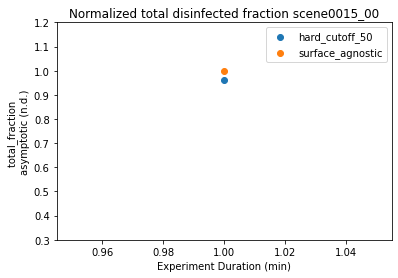

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./Semantic_results.csv',sep = '|')

tmp = df.experiment.str.split('_',expand = True)
names = tmp.loc[:,0] + '_' + tmp.loc[:,1]
names[names.str.startswith('hard')] += '_' + tmp.loc[names.str.startswith('hard'),2]
df['experiment_names'] = names

df2 = df[df.duration < 100]
max_disinf = df2.groupby(['mesh_name']).total_disinfected_fraction.max()

for tmp in df2.groupby('mesh_name'):
    room_name = tmp[0]
    max_disinfection = max_disinf[room_name]
    title = 'Normalized total disinfected fraction {}'.format(tmp[0])
    plt.title(title)
    tmp = tmp[1]
    for tmp2 in tmp.groupby('experiment_names'):
        name = tmp2[0]
        tmp2 = tmp2[1]
        plt.scatter(y = (tmp2.total_disinfected_fraction/max_disinfection),x = tmp2.duration,label = name)
    plt.legend()
    plt.xlabel('Experiment Duration (min)')
    plt.ylabel('total_fraction \nasymptotic (n.d.)')
    plt.ylim([0.3,1.2])
    plt.savefig('./media/semantic_results/{}.pdf'.format(title))
    plt.show()

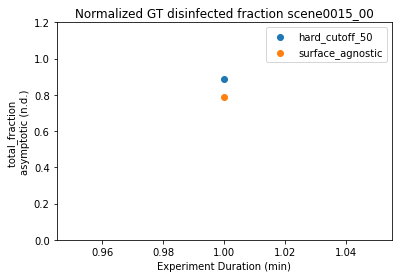

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./Semantic_results.csv',sep = '|')

tmp = df.experiment.str.split('_',expand = True)
names = tmp.loc[:,0] + '_' + tmp.loc[:,1]
names[names.str.startswith('hard')] += '_' + tmp.loc[names.str.startswith('hard'),2]
df['experiment_names'] = names

df2 = df[df.duration < 100]
max_disinf = df2.groupby(['mesh_name']).total_disinfected_fraction.max()

for tmp in df2.groupby('mesh_name'):
    room_name = tmp[0]
    max_disinfection = max_disinf[room_name]
    title = 'Normalized GT disinfected fraction {}'.format(tmp[0])
    plt.title(title)
    tmp = tmp[1]
    for tmp2 in tmp.groupby('experiment_names'):
        name = tmp2[0]
        tmp2 = tmp2[1]
        plt.scatter(y = (tmp2.ht_disinfected_fraction/max_disinfection),x = tmp2.duration,label = name)
    plt.legend()
    plt.xlabel('Experiment Duration (min)')
    plt.ylabel('total_fraction \nasymptotic (n.d.)')
    plt.ylim([0,1.2])
    plt.savefig('./media/semantic_results/{}.pdf'.format(title))
    plt.show()

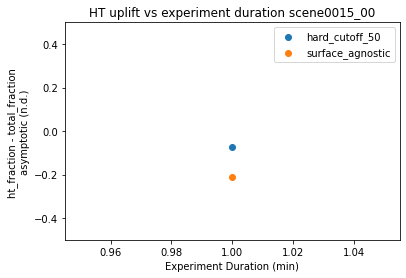

In [11]:

for tmp in df2.groupby('mesh_name'):
    room_name = tmp[0]
    max_disinfection = max_disinf[room_name]
    title = 'HT uplift vs experiment duration {}'.format(tmp[0])
    plt.title(title)
    tmp = tmp[1]
    for tmp2 in tmp.groupby('experiment_names'):
        name = tmp2[0]
        tmp2 = tmp2[1]
        plt.scatter(y = (tmp2.ht_disinfected_fraction/max_disinfection-tmp2.total_disinfected_fraction/max_disinfection),x = tmp2.duration,label = name)
    plt.legend()
    plt.xlabel('Experiment Duration (min)')
    plt.ylabel('ht_fraction - total_fraction \nasymptotic (n.d.)')
    plt.ylim([-0.5,0.5])
    plt.savefig('./media/semantic_results/{}.pdf'.format(title))
    plt.show()

# Plotting Code

In [ ]:
from glob import glob 
import pandas as pd
from matplotlib import pyplot as plt

all_meshes = glob('/home/motion//Optimized-UV-Disinfection/data/environment_meshes/aug_10_entire_val_ade20kmodel_vanilla_prob_weighting/estimated_scannet_val/*.ply')

meshes_series = pd.Series(all_meshes)
estimated_mask = ~meshes_series.str.split('/',expand = True).iloc[:,-1].str.startswith('gt')
# we now get the number of done meshes

# done_files = glob('/home/motion/Optimized-UV-Disinfection/3D_results/Semantic/*/{}/armbot/*'.format(experiment))
# if(done_files):
#     done_meshes = pd.Series(done_files).str.split('/',expand = True).iloc[:,-4].tolist()
# else:
#     done_meshes = []

estimated_meshes = sorted(meshes_series[estimated_mask].tolist())

In [ ]:
a = ['this is bullshit {}','this is super bullshit {}']
b = a[0].format(12)
a

In [ ]:
import pandas as pd
df = pd.read_csv('./Semantic_results_shorter_time.csv',sep = '|')

In [ ]:
tmp = df.experiment.str.split('_',expand = True)
names = tmp.loc[:,0] + '_' + tmp.loc[:,1]
names[names.str.startswith('hard')] += '_' + tmp.loc[names.str.startswith('hard'),2]
df['experiment_names'] = names

df2 = df[df.duration < 100]
max_disinf = df2.groupby(['mesh_name']).total_disinfected_fraction.max()

In [ ]:
for tmp in df2.groupby('mesh_name'):
    room_name = tmp[0]
    max_disinfection = max_disinf[room_name]
    title = 'HT uplift vs experiment duration {}'.format(tmp[0])
    plt.title(title)
    tmp = tmp[1]
    for tmp2 in tmp.groupby('experiment_names'):
        name = tmp2[0]
        tmp2 = tmp2[1]
        plt.scatter(y = (tmp2.ht_disinfected_fraction/max_disinfection-tmp2.total_disinfected_fraction/max_disinfection),x = tmp2.duration,label = name)
    plt.legend()
    plt.xlabel('Experiment Duration (min)')
    plt.ylabel('ht_fraction - total_fraction \nasymptotic (n.d.)')
    plt.ylim([-0.1,0.1])
    plt.savefig('./media/semantic_results/{}.pdf'.format(title))
    plt.show()

In [ ]:
tmp